# Part 4: Pronoun Use and Rhetorical Style in State of the Union Speeches

For this part, I use spaCy to analyze how U.S. presidents use pronouns such as **"I", "we", and "you"** in State of the Union speeches. The goal is to see how rhetorical style changes over time and across presidents.

This analysis uses:
- spaCy tokenization and part-of-speech tagging
- Lemmas and stop word filtering
- Per-speech features
- Visualizations over time, by president, and by crisis vs non-crisis years


In [1]:
# Dependencies
!pip install vaderSentiment
!pip install spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 44.6 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Imports and Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

sns.set(style="whitegrid")

In [3]:
# Load Data
df = pd.read_csv("data/SOTU.csv")

# Standardize column names
df.columns = df.columns.str.strip().str.lower()  # e.g. president, year, text, word count

# Ensure correct dtypes
df["year"] = df["year"].astype(int)
df["text"] = df["text"].astype(str)

df[["president", "year"]].head()

,president,year
0,Joseph R. Biden,2024
1,Joseph R. Biden,2023
2,Joseph R. Biden,2022
3,Joseph R. Biden,2021
4,Donald J. Trump,2020


In [4]:
# Initialize spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [5]:
# Function to count pronouns and token stats per document
def pronoun_counts(doc):
    i_sing = 0
    we_plur = 0
    you = 0
    total_tokens = 0
    content_tokens = 0  # alphabetic, non-stopword

    for token in doc:
        if token.is_alpha:
            total_tokens += 1
            if not token.is_stop:
                content_tokens += 1

        if token.pos_ == "PRON":
            lemma = token.lemma_.lower()
            if lemma in ("i", "me", "my", "mine", "myself"):
                i_sing += 1
            elif lemma in ("we", "us", "our", "ours", "ourselves"):
                we_plur += 1
            elif lemma in ("you", "your", "yours", "yourself", "yourselves"):
                you += 1

    return {
        "i_sing": i_sing,
        "we_plur": we_plur,
        "you": you,
        "total_tokens": total_tokens,
        "content_tokens": content_tokens,
    }

In [6]:
# Run spaCy and compute pronoun stats for each speech
texts = df["text"].tolist()
docs = list(nlp.pipe(texts, batch_size=8))  # adjust batch_size if needed

pron_data = [pronoun_counts(doc) for doc in docs]
pron_df = pd.DataFrame(pron_data)

df_pron = pd.concat([df.reset_index(drop=True),
                     pron_df.reset_index(drop=True)], axis=1)

df_pron.head()

,president,year,text,word count,i_sing,we_plur,you,total_tokens,content_tokens
0,Joseph R. Biden,2024,"\n[Before speaking, the President presented hi...",8003,270,156,112,8275,3885
1,Joseph R. Biden,2023,\nThe President. Mr. Speaker——\n[At this point...,8978,200,353,135,9233,4211
2,Joseph R. Biden,2022,"\nThe President. Thank you all very, very much...",7539,138,273,112,7692,3591
3,Joseph R. Biden,2021,\nThe President. Thank you. Thank you. Thank y...,7734,178,306,77,7905,3505
4,Donald J. Trump,2020,\nThe President. Thank you very much. Thank yo...,6169,89,203,91,6221,3114


In [7]:
# Compute pronoun rates per 1,000 content tokens

# Avoid division by zero
denom = df_pron["content_tokens"].replace(0, np.nan)

df_pron["i_per_1000"] = 1000 * df_pron["i_sing"] / denom
df_pron["we_per_1000"] = 1000 * df_pron["we_plur"] / denom
df_pron["you_per_1000"] = 1000 * df_pron["you"] / denom

df_pron[["president", "year", "i_per_1000", "we_per_1000", "you_per_1000"]].head()

,president,year,i_per_1000,we_per_1000,you_per_1000
0,Joseph R. Biden,2024,69.498069,40.154440,28.828829
1,Joseph R. Biden,2023,47.494657,83.828069,32.058893
2,Joseph R. Biden,2022,38.429407,76.023392,31.189084
3,Joseph R. Biden,2021,50.784593,87.303852,21.968616
4,Donald J. Trump,2020,28.580604,65.189467,29.222864


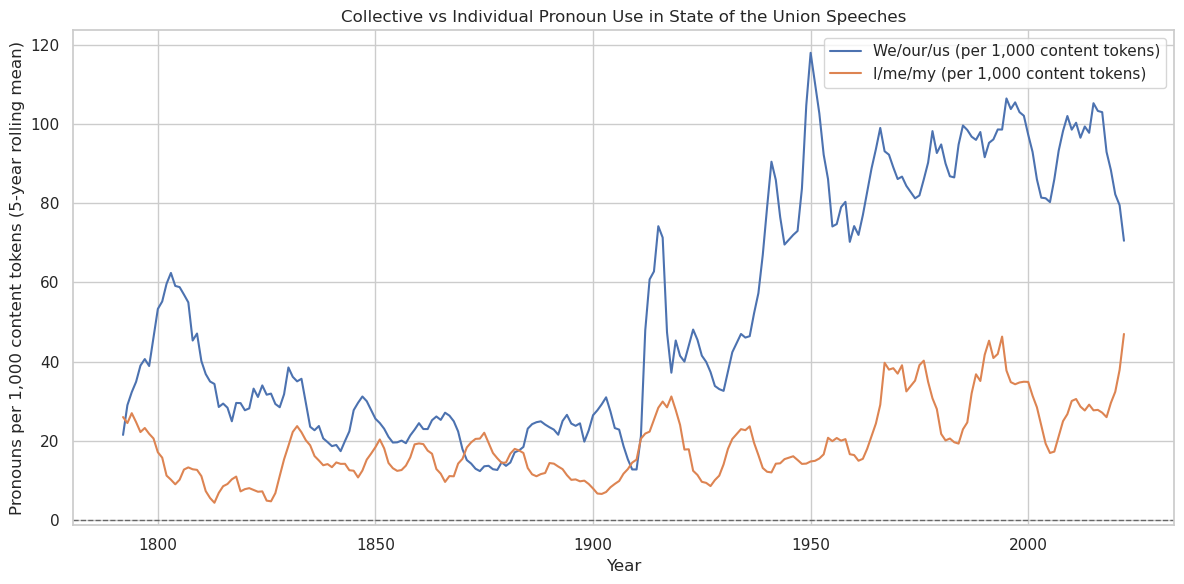

In [8]:
# Plot I vs We pronoun rates over time (5-year rolling averages)
yearly_pron = (
    df_pron.groupby("year")[["i_per_1000", "we_per_1000"]]
           .mean()
           .reset_index()
           .sort_values("year")
)

yearly_pron["i_rolling"] = yearly_pron["i_per_1000"].rolling(window=5, center=True).mean()
yearly_pron["we_rolling"] = yearly_pron["we_per_1000"].rolling(window=5, center=True).mean()

plt.figure(figsize=(12,6))
sns.lineplot(data=yearly_pron, x="year", y="we_rolling", label="We/our/us (per 1,000 content tokens)")
sns.lineplot(data=yearly_pron, x="year", y="i_rolling", label="I/me/my (per 1,000 content tokens)")
plt.title("Collective vs Individual Pronoun Use in State of the Union Speeches")
plt.xlabel("Year")
plt.ylabel("Pronouns per 1,000 content tokens (5-year rolling mean)")
plt.axhline(0, color="black", linewidth=1, linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

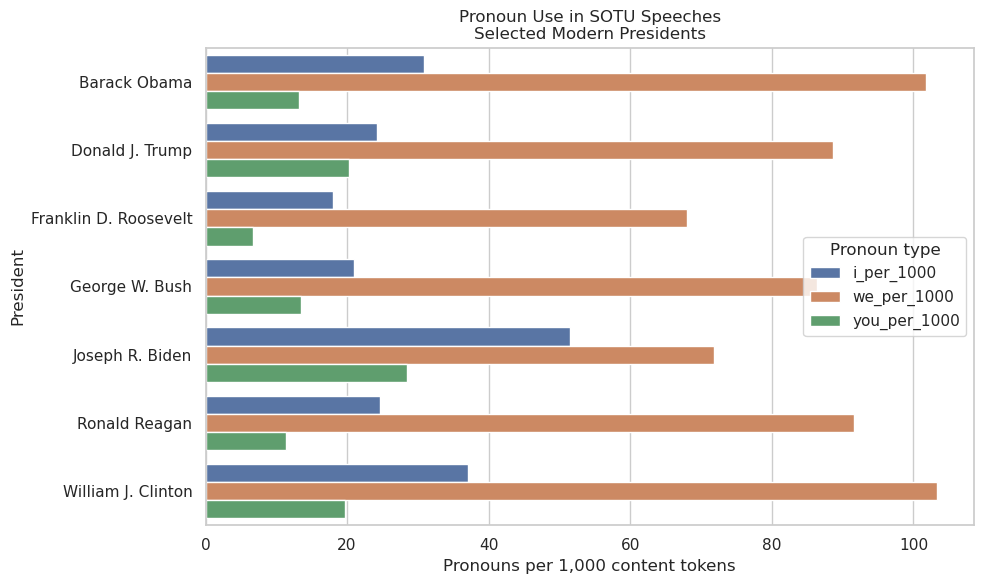

In [9]:
# Pronoun use for selected modern presidents
focus_pres = [
    "Franklin D. Roosevelt",
    "Ronald Reagan",
    "William J. Clinton",
    "George W. Bush",
    "Barack Obama",
    "Donald J. Trump",
    "Joseph R. Biden",
]

modern = df_pron[df_pron["president"].isin(focus_pres)].copy()

pres_stats = (
    modern.groupby("president")[["i_per_1000", "we_per_1000", "you_per_1000"]]
          .mean()
          .reset_index()
)

pres_long = pres_stats.melt(
    id_vars="president",
    value_vars=["i_per_1000", "we_per_1000", "you_per_1000"],
    var_name="pronoun_type",
    value_name="rate_per_1000",
)

plt.figure(figsize=(10,6))
sns.barplot(data=pres_long, x="rate_per_1000", y="president", hue="pronoun_type")
plt.title("Pronoun Use in SOTU Speeches\nSelected Modern Presidents")
plt.xlabel("Pronouns per 1,000 content tokens")
plt.ylabel("President")
plt.legend(title="Pronoun type")
plt.tight_layout()
plt.show()

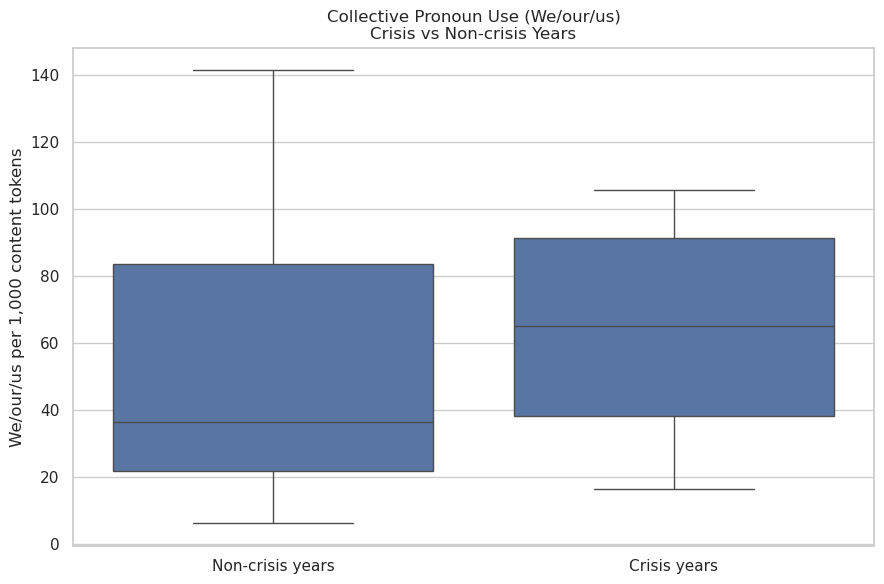

In [10]:
# Compare pronoun use in crisis vs non-crisis years
def is_crisis_year(year):
    crisis_ranges = [
        (1861, 1865),  # Civil War
        (1917, 1918),  # WWI (US involvement)
        (1933, 1945),  # Great Depression + WWII
        (2001, 2003),  # 9/11 and early War on Terror
        (2008, 2009),  # Financial crisis
        (2020, 2021),  # COVID-19
    ]
    for start, end in crisis_ranges:
        if start <= year <= end:
            return True
    return False

df_pron["crisis"] = df_pron["year"].apply(is_crisis_year)

plt.figure(figsize=(9,6))
sns.boxplot(data=df_pron, x="crisis", y="we_per_1000")
plt.xticks([0, 1], ["Non-crisis years", "Crisis years"])
plt.title("Collective Pronoun Use (We/our/us)\nCrisis vs Non-crisis Years")
plt.xlabel("")
plt.ylabel("We/our/us per 1,000 content tokens")
plt.tight_layout()
plt.show()

## Summary

- **Overview:**  
  I used spaCy to tokenize the State of the Union speeches, find pronouns via part-of-speech tags and lemmas, and filtered out stopwords to define a set of tokens for each speech. From this, I computed per-speech rates of first-person use of "I", first-person "we", and second-person "you" pronouns.

- **Trends over time:**  
  *"We" is consistently used over "I" for almost all periods of history for presidents, with the one exception between the 1850s and 1900s. Possibly to due with the Civil War*

- **Differences across modern presidents (Figure: president comparison):**  
  *All modern presidents have an affinity towards "I." One interesting thing to note is that Joseph R. Biden's use of "you" and "I" is higher than that of any other president, while "we" is lower than the others.*

- **Crisis vs non-crisis years (Figure: crisis boxplot):**  
  *Even though there was a brief stint of "I" being used more during the Civil War, other Crisis years seems to average out "We's" over "I's," as "we" is much more common during crisis years.*

- **Limitations and extensions:**  
  - Pronoun counts are a coarse measure and ignore sentence context.
  - Some presidents have relatively few speeches, leading to noisy averages.
  - Future extensions could combine this with topic modeling or sentiment analysis on the same speeches to connect rhetorical style with policy content.
